# Face Detect

In [1]:
import requests
import urllib
import matplotlib.image as mpimg
import json

image_path = "me.png"
url_face_api = 'https://api.projectoxford.ai/face/v1.0/detect'
api_key = 'Use sua chave da API aqui!'

headers = {'Content-Type': 'application/octet-stream', 'Ocp-Apim-Subscription-Key':api_key}

params = urllib.parse.urlencode({
    'returnFaceId': 'true',
    'returnFaceLandmarks': 'true',
    'returnFaceAttributes': 'age,gender,smile,facialHair,headPose,glasses',
})

query_string = '?{0}'.format(params)

url = url_face_api + query_string

with open(image_path, "rb") as imageFile:
    image_file = imageFile.read()
    blob = bytearray(image_file)


In [2]:
api_response = requests.post(url, headers=headers, data=blob)

res_json = json.loads(api_response.content.decode('utf-8'))

print(json.dumps(res_json, indent=2, sort_keys=True))

[
  {
    "faceAttributes": {
      "age": 33.8,
      "facialHair": {
        "beard": 0.2,
        "moustache": 0.1,
        "sideburns": 0.0
      },
      "gender": "male",
      "glasses": "Sunglasses",
      "headPose": {
        "pitch": 0.0,
        "roll": 1.2,
        "yaw": 2.6
      },
      "smile": 1.0
    },
    "faceId": "29e1d03f-bf3b-4035-973a-b9e587a22398",
    "faceLandmarks": {
      "eyeLeftBottom": {
        "x": 345.3,
        "y": 428.8
      },
      "eyeLeftInner": {
        "x": 349.4,
        "y": 427.5
      },
      "eyeLeftOuter": {
        "x": 341.0,
        "y": 427.6
      },
      "eyeLeftTop": {
        "x": 345.3,
        "y": 425.7
      },
      "eyeRightBottom": {
        "x": 373.3,
        "y": 428.6
      },
      "eyeRightInner": {
        "x": 369.2,
        "y": 427.3
      },
      "eyeRightOuter": {
        "x": 377.1,
        "y": 427.5
      },
      "eyeRightTop": {
        "x": 373.5,
        "y": 425.5
      },
      "eyebrowLeftIn

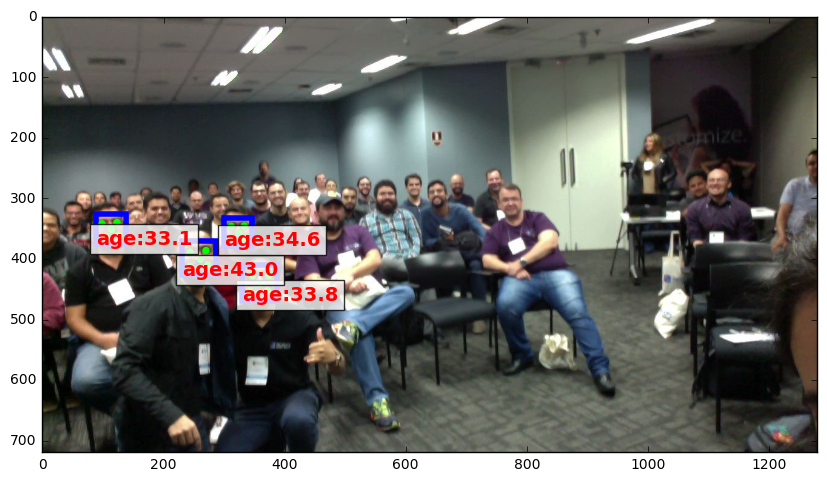

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

plt.figure(figsize=(10, 10))
ax = plt.gca()

# Desanha os retangulos para identificar as faces
for i in res_json:
    # Obtem o nó faceRectangle por face detectada na imagem
    fr = i['faceRectangle'] 

    pc = 'red' # patch color
    if i['faceAttributes']['gender'] == 'male':
        pc = 'blue'

    ax.add_patch(
        patches.Rectangle(
            (fr['left'], fr['top']), fr['width'], fr['height'],
            fill=False, linewidth=4, color=pc)
    )
    
    ax.text(fr['left'], fr['top']+fr['height'], 
            'age:'+str(i['faceAttributes']['age']), 
            fontsize=14, weight='bold', color='red', bbox=dict(facecolor='white', alpha=0.8))
    
# patch size
ps = 5      
# patch color
pc = '#00FF00'   

# Desenhas os pontos para eye, nose, mouth
for i in res_json:
    fl = i['faceLandmarks']

    # Olho esquerdo
    ax.add_patch(patches.Circle((fl['pupilLeft']['x'], fl['pupilLeft']['y']), ps, color=pc))

    # Olho direito
    ax.add_patch(patches.Circle((fl['pupilRight']['x'], fl['pupilRight']['y']), ps, color=pc))

    # Boca
    ax.add_patch(patches.Circle((fl['mouthLeft']['x'], fl['mouthLeft']['y']), ps, color=pc))
    ax.add_patch(patches.Circle((fl['mouthRight']['x'], fl['mouthRight']['y']), ps, color=pc))

    # Nariz
    ax.add_patch(patches.Circle((fl['noseTip']['x'], fl['noseTip']['y']), ps, color=pc))

# Exibe a imagem    
img = mpimg.imread(image_path)    
plt.imshow(img)